# Download Waveforms to Segments

In [ ]:
import os
import sys
srcpath = os.path.realpath('../SourceFiles')
sys.path.append(srcpath)
import pyte_visa_utils as pyte

In [2]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [30]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = 'TCPIP::192.168.0.60::5025::SOCKET'

inst = pyte.open_session(inst_addr)
resp = inst.query("*IDN?")
print('connected to: ' + resp)

connected to: Tabor Electronics,P2584M,000000220725,1.114.0


## Before we start

It is highly recommended to append `*OPC?` to any SCPI statement that contains no other query.  
For example, instead of sending the bare command `:OUTPut ON`, send a compound query `:OUTPut ON; *OPC?`  
In that way the calling application ensures that the command execution has been completed before it sends the next command.  

The function `send_cmd(vi, cmd_str, paranoia_level=1)` from `pyte` module does that for you.
 - If `paranoia_level = 0` then it sends the given SCPI command `cmd_str` without any additional query.
 - If `paranoia_level = 1` then it appends `*OPC?` to the given `cmd_str`, and sends the compound statement as query.
 - If `paranoia_level = 2` then it appends `:SYST:ERR?`to the given `cmd_str`, and prints warning in case of error.


When sending binary data, the `*OPC?` is added **before** to the command.    
For example `*OPC?; :TRACe:DATA #<bianry-header><binary-block>`, and the response is read separately  
after all the binary-data has been sent (the caller might need to enlarge the time-out in that case).

In [6]:
# Paranoia Level (0: low, 1: normal, 2: debug)
paranoia_level = 2

# Reset the instrument
pyte.send_cmd(inst, '*CLS; *RST', paranoia_level)

In [7]:
# Get DAC Mode
resp = inst.query(":SYST:INFormation:DAC?")
print("DAC-Mode: " + resp)
dac_mode = int(resp)

# Get number of channels
resp = inst.query(":INST:CHAN? MAX")
print("Number of channels: " + resp)
num_channels = int(resp)

# Get the maximal number of segments
resp = inst.query(":TRACe:SELect:SEGMent? MAX")
print("Max segment number: " + resp)
max_seg_number = int(resp)

# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

max_dac = 2 ** dac_mode - 1
half_dac = max_dac / 2.0


DAC-Mode: 16
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 4,286,578,688 wave-bytes


## Writing waveform data to segment

The command `:TRACE:DATA [<offset-in-bytes>] #<binary-header><binary-data>`  
writes the given block of binary data to the specified offset in the selected segment of the selected channel.

#### The header of the binary-data block
The SCPI protocol uses text-based messages, and the new-line character denotes end of a SCPI statement.<br>
In case of binary-data the sender must send a header that defines the size of the binary block before the data  
because the new-line character can be a part of the data.<br>

The header is composed of `'#'` character followed by a sequence of between 2 and 10 decimal digits, where the<br>
first digits denotes how many digits follows it (between 1 and 9) and the rest of the digits denote the size of the<br>
binary-block in bytes. For example, `#3256` denotes block of 256 bytes, and `#41024` denotes block of 1024 bytes.

#### Note
In case of 16-bits DAC mode, each DAC has two channels that share the same segment-table and memory-space.  
So, in case of 16-bit DAC, segment 1 of channel 1 and segment 1 of channel 2 are identical. It might be a bit confusing  
at first, but it gives more flexability (for example, a higher limit to the segment size).  

### Simple example
Download waves to several segments and play different segment in each channel.  

The function `write_binary_values(message, values, datatype)` from `pyvisa` module is used for sending waveform data.<br>
It adds appropriate *binary-header* to the given SCPI `message` according to the length of the `values` array<br>
and the `datatype` argument, which, in case of waveform, is either `'B'` (for `uint8`) or `'H'` (for `uint16`).

See the definition of __[write_binary_values](https://pyvisa.readthedocs.io/en/latest/api/resources.html#pyvisa.resources.MessageBasedResource.write_binary_values)__,
and the __[list](https://docs.python.org/3/library/struct.html#format-characters)__ of `datatype` codes.




In [8]:
# Build 12 waveforms

seglen = 81920
num_cycles = (1, 2, 4, 8)

waves = [ None for _ in range(12)]

for ii in range(4):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
    y = (np.sin(x) + 1.0) * half_dac
    y = np.round(y)
    y = np.clip(y, 0, max_dac)
    if dac_mode == 16:
        waves[ii] = y.astype(np.uint16)
    else:
        waves[ii] = y.astype(np.uint8)
    
for ii in range(4):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=seglen, endpoint=False)
    y = np.sin(x)
    y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
    y = np.round(y)
    y = np.clip(y, 0, max_dac)
    if dac_mode == 16:
        waves[ii + 4] = y.astype(np.uint16)
    else:
        waves[ii + 4] = y.astype(np.uint8)
    
for ii in range(4):
    ncycles = num_cycles[ii]
    cyclelen = seglen / ncycles
    
    x = np.linspace(start=0, stop=seglen, num=seglen, endpoint=False)
    y = np.fmod(x, cyclelen)
    y = (y <= cyclelen / 2) * max_dac
    y = np.round(y)
    y = np.clip(y, 0, max_dac)
    if dac_mode == 16:
        waves[ii + 8] = y.astype(np.uint16)
    else:
        waves[ii + 8] = y.astype(np.uint8)
 

In [9]:
# Download segments

# data-type code: 'B' = uint8, 'H' = uint16
data_type = 'H' if dac_mode == 16 else 'B'

for ii in range(num_channels):
    ichan = ii
    channb = ichan + 1
    segnum = ichan % 2 + 1
    wav = waves[ichan]
    print('Download wave to segment {0} of channel {1}'.format(segnum, channb))
    
    # Select channel
    cmd = ':INST:CHAN {0}'.format(channb)
    pyte.send_cmd(inst, cmd, paranoia_level)
    
    # Define segment
    cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
    pyte.send_cmd(inst, cmd, paranoia_level)
    
    # Select the segment
    cmd = ':TRAC:SEL {0}'.format(segnum)
    pyte.send_cmd(inst, cmd, paranoia_level)
    
    # Increase the timeout before writing binary-data:
    inst.timeout = 30000
    
    # Send the binary-data with *OPC? added to the beginning of its prefix.
    inst.write_binary_values('*OPC?; :TRAC:DATA', wav, datatype=data_type)
    
    # Read the response to the *OPC? query that was added to the prefix of the binary data
    resp = inst.read()
    
    # Set normal timeout
    inst.timeout = 10000
    
    resp = inst.query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    # Play the specified segment at the selected channel:
    cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
    pyte.send_cmd(inst, cmd, paranoia_level)

    # Turn on the output of the selected channel:
    cmd = ':OUTP ON'
    pyte.send_cmd(inst, cmd, paranoia_level)
    
    resp = inst.query(':SYST:ERR?')
    print(resp)

print()

resp = inst.query(':SYST:ERR?')
print(resp)

del waves
del wav

Download wave to segment 1 of channel 1
0, no error
Download wave to segment 2 of channel 2
0, no error
Download wave to segment 1 of channel 3
0, no error
Download wave to segment 2 of channel 4
0, no error

0, no error


## Reading data from segment 

The query `:TRACE:DATA? <offset-in-bytes>,<size-in-bytes>` is used for reading  
the specified amount of data from the specified offset at the selected segment of the selected channel. 

The response from the instrument is of the form `#<binary-header><binary-block>`  
where the binary-header has the same formt as before. There is no need to add `*OPC?` in this case, because it is query.  

In this example, the function `query_binary_values(message, datatype)` from `pyvisa` module is used for reading binary-data.

It parses the binary-header and returns the binary data.

See the definition of __[query_binary_values](https://pyvisa.readthedocs.io/en/latest/api/resources.html#pyvisa.resources.MessageBasedResource.query_binary_values)__.



In [10]:
offset_in_bytes = 0
size_in_bytes = 2 * seglen if dac_mode == 16 else seglen
# data-type code: 'B' = uint8, 'H' = uint16
data_type = 'H' if dac_mode == 16 else 'B'

waves = [None for _ in range(num_channels)]

for ii in range(num_channels):
    ichan = ii
    channb = ichan + 1
    segnum = ichan % 2 + 1
    print('Read wave from segment {0} of channel {1}'.format(segnum, channb))
    
    # Select channel
    cmd = ':INST:CHAN {0}'.format(channb)
    pyte.send_cmd(inst, cmd, paranoia_level)
    
    # Select segment
    cmd = ':TRAC:SEL {0}'.format(segnum)
    pyte.send_cmd(inst, cmd, paranoia_level)
    
    # Increase the timeout before reading binary-data:
    inst.timeout = 30000
    
    # There is no need to add '*OPC?' because it is a query
    cmd = ':TRAC:DATA? {0}, {1}'.format(offset_in_bytes, size_in_bytes)
    wav = inst.query_binary_values(cmd, datatype=data_type)
    
    # Set normal timeout
    inst.timeout = 10000
    
    waves[ii] = np.array(wav)
    del wav
    
    resp = inst.query(':SYST:ERR?')
    print(resp)

Read wave from segment 1 of channel 1
0, no error
Read wave from segment 2 of channel 2
0, no error
Read wave from segment 1 of channel 3
0, no error
Read wave from segment 2 of channel 4
0, no error


<IPython.core.display.Javascript object>


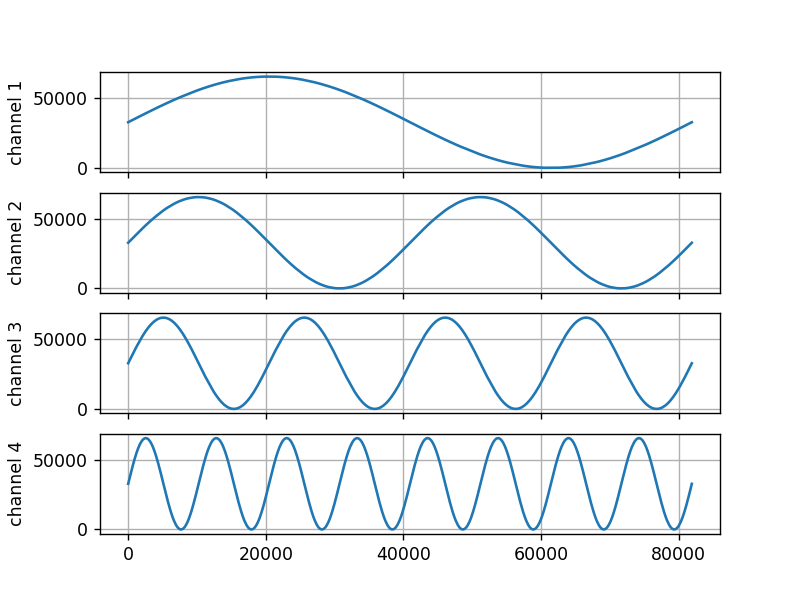

In [11]:
# Plot the waves
x = np.arange(seglen)

fig1, axs = plt.subplots(nrows=num_channels, ncols=1, sharex=True, num=1, clear=True)
for ii in range(num_channels):
    axs[ii].plot(x, waves[ii])
    axs[ii].set_ylabel('channel {0}'.format(ii + 1))
    axs[ii].grid(True)

plt.show()
del x, waves

## Use `:TRACE:DATA` command with *offset* parameter for large segment

The format of the [binary-header](#The-header-of-the-binary-data-block) limits the maximal block-size to $10^9-1$ bytes.

Therefore, when dealing with large segments, one should use the *offset* parameter <br>
of the `:TRACE:DATA` command, and write (or read) data in chunks (to varying offsets inside the segment).<br>

#### Important
For efficiency, the size of each chunk except the last one should be between about 1MB and a few MB <br>
where 1MB is $2^{20}=1024^2=1048576$ bytes, and both the chunk-size and the offset should be multiplications of 64.

In [44]:
channb = 1
segnum = 1

totsize = (arbmem_capacity // 64) * 1
chunksize = min(2**20, totsize)
if dac_mode == 16:
    seglen  = totsize // 2
    chunklen = chunksize // 2
else:
    seglen  = totsize
    chunklen = chunksize

# Reset the instrument
pyte.send_cmd(inst, '*CLS; *RST', paranoia_level)

# Select channel
cmd = ':INST:CHAN {0}'.format(channb)
pyte.send_cmd(inst, cmd, paranoia_level)

# Define segment
cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
pyte.send_cmd(inst, cmd, paranoia_level)

# Select the segment
cmd = ':TRAC:SEL {0}'.format(segnum)
pyte.send_cmd(inst, cmd, paranoia_level)

offset = 0
ncycles = 1

# Increase the timeout before writing binary-data:
inst.timeout = 30000

print()
msg = 'Wrote {0:,} bytes out of {1:,}'.format(offset, totsize)
print(msg, end='')

while offset < totsize:
    
    # prepare chunk of waveform data
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=chunklen, endpoint=False)
    y = (np.sin(x) + 1.0) * half_dac
    y = np.round(y)
    y = np.clip(y, 0, max_dac)
    if dac_mode == 16:
        y = y.astype(np.uint16)
    else:
        y = y.astype(np.uint8)
    
    if totsize - offset < chunksize:
        chunksize = totsize - offset
        if dac_mode == 16:
            chunklen = chunksize // 2
        else:
            chunklen = chunksize
        y = y[0:chunklen]
            
    # Send the binary-data with *OPC? added to the beginning of its prefix.
    cmd = '*OPC?; :TRAC:DATA {0}'.format(offset)
    inst.write_binary_values(cmd, y, datatype=data_type)
    
    # Read the response to the *OPC? query that was added to the prefix of the binary data
    resp = inst.read()
    
    offset = offset + chunksize
    ncycles = (ncycles % 1024) + 1
    
    # Print progress
    if len(msg) > 0:
        print('\r', end='') 
        print(' ' * len(msg), end='')
        print('\r', end='')
    msg = 'Wrote {0:,} bytes out of {1:,}'.format(offset, totsize)
    print(msg, end='')

print('\n')

# Set normal timeout
inst.timeout = 10000

del x, y

resp = inst.query(':SYST:ERR?')
print(resp)

# Play the specified segment at the selected channel:
cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(segnum)
pyte.send_cmd(inst, cmd, paranoia_level)

# Turn on the output of the selected channel:
cmd = ':OUTP ON'
pyte.send_cmd(inst, cmd, paranoia_level)


Wrote 66,977,792 bytes out of 66,977,792

0, no error


In [45]:
# Reset the instrument
pyte.send_cmd(inst, '*CLS; *RST', paranoia_level)

In [50]:
# Read the data in chunks and validate each chunk

offset = 0
ncycles = 1

# Increase the timeout before writing binary-data:
inst.timeout = 30000

print()
msg = 'Read {0:,} bytes out of {1:,}'.format(offset, totsize)
print(msg, end='')

resp = inst.query(':SYST:ERR?')
print(resp)

while offset < totsize:
    
    # prepare chunk of waveform data (for comparison)
    x = np.linspace(
        start=0, stop=2 * np.pi * ncycles, num=chunklen, endpoint=False)
    y = (np.sin(x) + 1.0) * half_dac
    y = np.round(y)
    y = np.clip(y, 0, max_dac)
    if dac_mode == 16:
        y = y.astype(np.uint16)
    else:
        y = y.astype(np.uint8)
    
    if totsize - offset < chunksize:
        chunksize = totsize - offset
        if dac_mode == 16:
            chunklen = chunksize // 2
        else:
            chunklen = chunksize
        y = y[0:chunklen]
            
    # Read chunk of binary data
    cmd = ':TRAC:DATA? {0},{1}'.format(offset, chunksize)
    wav = inst.query_binary_values(cmd, datatype=data_type)
    wav = np.array(wav)
    
    #resp = inst.query(':SYST:ERR?')
    #print(resp)

    # Compare it to the expected data
    if not np.array_equal(wav,y):
        msg = ''
        print('\nComparison failed!\n')    
    
    offset = offset + chunksize
    ncycles = (ncycles % 1024) + 1
    
    # Print progress
    if len(msg) > 0:
        print('\r', end='') 
        print(' ' * len(msg), end='')
        print('\r', end='')
    msg = 'Read {0:,} bytes out of {1:,}'.format(offset, totsize)
    print(msg, end='')

print('\n')

# Set normal timeout
inst.timeout = 10000

del x, y

resp = inst.query(':SYST:ERR?')
print(resp)


Read 0 bytes out of 66,977,792221, illegal argument

Comparison failed!

Read 917,504 bytes out of 66,977,792
Comparison failed!

Read 1,835,008 bytes out of 66,977,792
Comparison failed!

Read 2,752,512 bytes out of 66,977,792
Comparison failed!

Read 3,670,016 bytes out of 66,977,792
Comparison failed!

Read 4,587,520 bytes out of 66,977,792
Comparison failed!

Read 5,505,024 bytes out of 66,977,792
Comparison failed!

Read 6,422,528 bytes out of 66,977,792
Comparison failed!

Read 7,340,032 bytes out of 66,977,792
Comparison failed!

Read 8,257,536 bytes out of 66,977,792
Comparison failed!

Read 9,175,040 bytes out of 66,977,792
Comparison failed!

Read 10,092,544 bytes out of 66,977,792
Comparison failed!

Read 11,010,048 bytes out of 66,977,792
Comparison failed!

Read 11,927,552 bytes out of 66,977,792
Comparison failed!

Read 12,845,056 bytes out of 66,977,792
Comparison failed!

Read 13,762,560 bytes out of 66,977,792
Comparison failed!

Read 14,680,064 bytes out of 66,977,79

## Use `:TRACe:SEGMents[:DATA]` and `:TRACe:MEMory` for multiple segments

#### The command `:TRACe:SEGMents[:DATA] [<first-segment-number>] #<binary-header><binary-data>`
This command defines multiple simple segments in the segment-table of the selected channel.<br>

 - The binary-data consists of *N* `uint64` values with the lengths of *N* segments, expressed in **bytes** of wave-data<br>
   (in that aspect it differs from the `:TRACe:DEFine` command that receives the segment-length in points).
 - The *first-segment-number* is an optional argument (the default is 1).<br>

When the command is executed it first resets the segment-table of the selected channel (like `:TRACe:DELete:ALL`),<br>
and then defines *N* segments of the given lengths and consecutive segment-numbers starting from *first-segment-number*.<br>

The memory for the segments is allocated continuously **from the beginning of memory-space** (of the selected channel).<br>
Therefore it is possible to use `TRACe:MEMory` for downloading waveform data to all the *N* segments.<br>

It is still possible, of course, to write (or read) data from each segment with `:TRACe:DATA`, but if, for example,<br>
one defines a large number of relatively small segments, then writing the waveform data in chunks of 1MB can be faster.

#### The command `:TRACe:MEMory [<offset-in-bytes-of-wave-data>] #<binary-header><binary-data>`
This command (or query) is the same as `:TRACe[:DATA]  [<offset-in-bytes-of-wave-data>] #<binary-header><binary-data>`<br>
except that the offset, in case of `:TRACe:MEMory`, is from the beginning of the memory-space rather than the beginning<br>
of memory of the selected segment.

### Caution

If a segment size (in bytes of waveform data) is not divisible by 64, which is legal for fast segments only,<br>
then the location of the next segment in memory is at the first offset in the memory-space that is divisible by 64.<br>
It is the responsibility of the user to pad the gap when using `:TRACe:MEMory`.

In [41]:
numsegs = 256
first_seg_size = 256
delta_seg_size = 64
last_seg_size = first_seg_size + delta_seg_size * (numsegs - 1)
total_size = (first_seg_size + last_seg_size) * numsegs // 2

if dac_mode == 16:
    bpp = 2    
    total_length = total_size // 2
    first_seg_len = first_seg_size // 2
    delta_seg_len = delta_seg_size // 2
else:
    bpp = 1
    total_length = total_size
    first_seg_len = first_seg_size
    delta_seg_len = delta_seg_size
    
print('total-length: {0:,}, total-size: {1:,}'.format(total_length, total_size))

seg_sizes = np.zeros(numsegs, dtype=np.uint64)
for n in range(numsegs):
    seg_sizes[n] = np.uint64(first_seg_size + n * delta_seg_size)
    
# Reset the instrument
pyte.send_cmd(inst, '*CLS; *RST;', paranoia_level)

# Select channel 1
pyte.send_cmd(inst, ':INST:CHAN 1', paranoia_level)
    
# Increase the timeout before writing binary-data:
inst.timeout = 30000

# Send the list of segment-sizes as binary-data (datatype='Q' for uint64)
cmd = '*OPC?; :TRAC:SEGM'
inst.write_binary_values(cmd, seg_sizes, datatype='Q')

# Read the response to the *OPC? query that was added to the prefix of the binary data
resp = inst.read()

# Set normal timeout
inst.timeout = 10000

resp = inst.query(':SYST:ERR?')
print(resp)

# Build waveform data for all segments
if dac_mode == 16:
    wavdat = np.empty(total_length, dtype=np.uint16)
else:
    wavdat = np.empty(total_length, dtype=np.uint8)

offset = 0
for iseg in range(numsegs):
    seglen = int(seg_sizes[iseg] // bpp)    
    x = np.linspace(
        start=0, stop=2 * np.pi, num=seglen, endpoint=False)
    y = (np.sin(x) + 1.0) * half_dac
    y = np.round(y)
    y = np.clip(y, 0, max_dac)
    if dac_mode == 16:
        y = y.astype(np.uint16)
    else:
        y = y.astype(np.uint8)
            
    wavdat[offset: offset + seglen] = y
    offset = offset + seglen

    del x, y

data_type = 'H' if dac_mode == 16 else 'B'

# Increase the timeout before writing binary-data:
inst.timeout = 30000

# Write the waveform data from the beginning of the memory-space
cmd = '*OPC?; :TRAC:MEM'
inst.write_binary_values(cmd, wavdat, datatype=data_type)
    
# Read the response to the *OPC? query that was added to the prefix of the binary data
resp = inst.read()

# Set normal timeout
inst.timeout = 10000

resp = inst.query(':SYST:ERR?')
print(resp)

# Play the segment 1 at the selected channel:
pyte.send_cmd(inst, ':SOUR:FUNC:MODE:SEGM 1', paranoia_level)

# Turn on the output of the selected channel:
pyte.send_cmd(inst, ':OUTP ON', paranoia_level)

total-length: 1,077,248, total-size: 2,154,496
0, no error
0, no error


In [42]:
# Validations

# 1. Read back the whole data and compare to the data that we've written
offset_in_bytes = 0
size_in_bytes = total_size
cmd = ':TRAC:MEM? {0},{1}'.format(offset_in_bytes, size_in_bytes)

inst.timeout = 30000
y = inst.query_binary_values(cmd, datatype=data_type)
inst.timeout = 10000

resp = inst.query(':SYST:ERR?')
print(resp)

if dac_mode == 16:
    y = np.array(y, dtype=np.uint16)
else:
    y = np.array(y, dtype=np.uint8)
    
if not np.array_equal(wavdat,y):
    print('\nComparison failed!\n')
    print('\nwavdat')
    print('length={0}, type={1}'.format(len(wavdat), wavdat.dtype))
    print('\ny')
    print('length={0}, type={1}'.format(len(y), y.dtype))

# 2. Query segments lengths and compare to the lengths we've written
for iseg in range(numsegs):
    expected_len = int(seg_sizes[iseg] // bpp)
    resp = inst.query(':TRAC:SEL {0}; :TRAC:DEF:LENG?'.format(iseg + 1))
    try:
        actual_len = int(resp)
    except:
        actual_len = -1
    
    if actual_len != expected_len:
        msg = 'segment {0}: expected-length: {1}, actual-length: {2}'.format(iseg + 1, expected_len, actual_len)
        print(msg)
        break

# 3. Read the data of each segment and make sure it is as expected
offset = 0
for iseg in range(numsegs):
    seglen = int(seg_sizes[iseg] // bpp)
    
    wexp = wavdat[offset: offset + seglen]
    
    offset_in_bytes = offset * bpp
    size_in_bytes = seglen * bpp
    cmd = ':TRAC:MEM? {0},{1}'.format(offset_in_bytes, size_in_bytes)
    
    inst.timeout = 30000
    wact = inst.query_binary_values(cmd, datatype=data_type)
    inst.timeout = 10000
    
    if dac_mode == 16:
        wact = np.array(wact, dtype=np.uint16)
    else:
        wact = np.array(wact, dtype=np.uint8)
    if not np.array_equal(wexp,wact):
        msg = 'Comparison failed on segment {0} (length {1}).'.format(iseg + 1,seglen )
        print(msg)
        break
    
    offset = offset + seglen
    del wact, wexp

0, no error


In [43]:
# Change the segment that being played in channel 1,
# and play all segments one after the other with some time-delay

for iseg in range(numsegs):    
    cmd = ':SOUR:FUNC:MODE:SEGM {0}'.format(iseg + 1)
    pyte.send_cmd(inst, cmd, paranoia_level)
    time.sleep(0.5)

KeyboardInterrupt: 